In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import time


In [2]:
''' self device cuda check '''

print("device count: {}".format(torch.cuda.device_count()))

print("current device id: {}".format(torch.cuda.current_device()))

print("device addr: {}".format(torch.cuda.device(0)))

print("device name: {}".format(torch.cuda.get_device_name(0)))

print("cuda is available: {}".format(torch.cuda.is_available()))

device count: 1
current device id: 0
device addr: <torch.cuda.device object at 0x00000245677A1240>
device name: GeForce GTX 1050 Ti
cuda is available: True


In [35]:
''' preprocess data '''

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


50000
10000


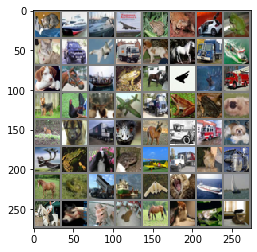

  cat  ship  ship plane


In [4]:
''' show data '''
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random testing images
dataiter = iter(testloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
class CNN_Net(nn.Module):
    def __init__(self):
        super(CNN_Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.layer_norm1 = nn.LayerNorm([64, 16, 16])
        
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        y = self.pool(F.relu(self.conv1(x))) # conv + max pooling
        
        y = self.layer_norm1(y) # layer norm
        
        y = y.view(y.size(0), -1) # flatten
        
        # fully connected network
        y = F.relu(self.fc1(y))
        y = F.relu(self.fc2(y))
        y = self.fc3(y)
        
        return y

In [6]:
class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self,in_dim,activation):
        super(Self_Attn,self).__init__()
        self.chanel_in = in_dim
        self.activation = activation
        
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1)
        
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X C X (N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        print(proj_query.shape)
        print(proj_key.shape)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # B X (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1))
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out,attention

In [7]:
class SELayer(nn.Module):
    def __init__(self, channel, reduction=8):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.5) 
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        
        y = self.avg_pool(x).view(b, c)
        
        y = self.fc(y)

        y = self.dropout(y)
        
        y = y.view(b, c, 1, 1)
        
        return x * y.expand_as(x)

In [8]:
class SE_Attn(nn.Module):
    def __init__(self,in_dim):
        super(SE_Attn,self).__init__()
        self.in_channel = in_dim
        
        self.se_q = SELayer(in_dim)
        self.se_k = SELayer(in_dim)
        self.se_v = SELayer(in_dim)
        
        self.activation = 'relu'
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax  = nn.Softmax(dim=-1)
        
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        
        q = self.se_q(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X (W * H) X C  
        k = self.se_k(x).view(m_batchsize,-1,width*height) # B X C x (W * H)  
        v = self.se_v(x).view(m_batchsize,-1,width*height) # B X C X N  
        
        # matmul(q, k) and softmax
        energy =  torch.bmm(q,k) 
        attention = self.softmax(energy) # B X (N) X (N) 
        
        # matmul(v, attn)
        out = torch.bmm(v,attention.permute(0,2,1)) # mutmul
        
        out = out.view(m_batchsize,C,width,height) # reshape
        
        out = self.gamma*out + x

        return out, attention

In [9]:
class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.se_attns = nn.ModuleList([SE_Attn(64) for i in range(1)])
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        
        self.layer_norm1 = nn.LayerNorm([64, 16, 16])
        
        self.fc1 = nn.Linear(64 * 16 * 16, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 10)
        
    def forward(self, x):
        y = self.pool(F.relu(self.conv1(x))) # conv + max pooling
        for se_attn in self.se_attns:
            se_attn_y, attention = se_attn(y)
            y = self.layer_norm1(se_attn_y) # add and layer norm
        
        y = y.view(y.size(0), -1) # flatten
        
        # fully connected network
        y = F.relu(self.fc1(y))
        y = F.relu(self.fc2(y))
        y = F.relu(self.fc3(y))
        y = self.fc4(y)
        
        return y, attention

In [21]:
''' test self attn network (cpu) '''

# get some random training images
dataiter = iter(trainloader)
inputs, labels = dataiter.next()
print(inputs.shape)

# test net
net = EncoderLayer()
outputs, attention = net(inputs)
print(outputs.shape)
print(attention.shape)

torch.Size([64, 3, 32, 32])
torch.Size([64, 10])
torch.Size([64, 256, 256])


In [27]:
''' training '''

PATH = './sa_net.pth'

# build net
net = EncoderLayer()
net.cuda()
net.train()

# load pretraing model
net.load_state_dict(torch.load(PATH))

# initial loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# training
t0 = time.time()
for epoch in range(2):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # transform cuda data
        inputs = inputs.cuda()
        labels = labels.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, attention = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

# save model
torch.save(net.state_dict(), PATH)

t1 = time.time()
print('Finished Training (GPU)')
print("time: {:f} sec".format(t1 - t0))

Finished Training (GPU)
time: 85.092816 sec


In [28]:
''' train acc '''
PATH = './sa_net.pth'
net = EncoderLayer()
net.cuda()
net.load_state_dict(torch.load(PATH))
net.eval()

correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # transform cuda data
            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs, attention = net(inputs)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()


print('train acc: {}'.format(correct/total))

train acc: 0.96802


In [29]:
''' test acc '''
PATH = './sa_net.pth'
net = EncoderLayer()
net.cuda()
net.load_state_dict(torch.load(PATH))
net.eval()

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # transform cuda data
            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs, attention = net(inputs)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

print('test acc: {}'.format(correct/total))

test acc: 0.6835


In [30]:
def img_transform(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

def plot_attn(images,attention):
    
    fig1 = plt.figure(figsize=(16,7))
    fig2 = plt.figure(figsize=(16,7))
    
    for i, (img, attn) in enumerate(zip(images, attention)):
        
        img = img_transform(img)
        
        # attention weight N x N (N = W x H)
        attn = attn.detach().numpy() 
    
        # diagonal attention is image pixel attention weight
        img_attn = np.reshape(attn.diagonal(),(16,16)) 
        
        ax1 = fig1.add_subplot(1,4,i+1)
        ax2 = fig2.add_subplot(1,4,i+1)
        ax1.imshow(img)
        ax2.matshow(img_attn,cmap='binary')
        
    plt.show() 

GroundTruth:    cat  ship  ship plane
Predicted:    dog  ship plane  ship


ValueError: num must be 1 <= num <= 4, not 5

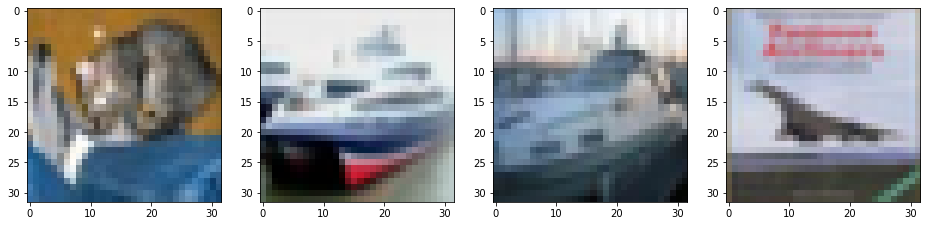

In [ ]:
''' show test data predict result '''

# load data
dataiter = iter(testloader)
images, labels = dataiter.next()

# load net
PATH = './sa_net.pth'
net = EncoderLayer()
net.load_state_dict(torch.load(PATH))
net.eval()

# predict images
outputs, attention = net(images)
_, predicted = torch.max(outputs, 1)


# show predicted result
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

# show images and attn
plot_attn(images,attention)